In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [67]:
df_initial = pd.read_csv("dataframe_nettoye.csv")


In [68]:
df_initial.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr            277479
LowDoc                    0
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
has_chgoff_date           0
bool_RetainedJob          0
bool_CreateJob            0
Recession                 0
dtype: int64

In [69]:
df_initial = df_initial.dropna(subset=["RevLineCr"])



In [70]:
df_initial.isna().sum()
df_initial["RevLineCr"].unique()

array(['N', 'Y'], dtype=object)

# fonctions affichage metriques et auc

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# métriques
def metriques(pipeline, X_test, y_test) :
    y_pred = pipeline.predict(X_test)
    
    # Métriques d'évaluation
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"F1-score macro : {f1_macro}")

    matrice_confusion = confusion_matrix(y_test, y_pred)
    matrice_percentage = matrice_confusion.astype('float') / matrice_confusion.sum(axis=1)[:, np.newaxis] * 100
    matrice_percentage
    
# courbe AUC
def courbe_AUC(pipeline, X_test, y_test) :
    from sklearn.metrics import roc_curve, auc
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
def best_params_to_csv(random_search):
    nom_classifier = random_search.estimator.named_steps[list(random_search.estimator.named_steps.keys())[-1]].__class__.__name__
    params_top = pd.DataFrame([random_search.best_params_])
    params_top.to_csv(f"best_params_{nom_classifier}.csv", index=False)


# pipeline

In [72]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler


df = df_initial.copy()

df["MIS_Status"] = df["MIS_Status"].map({"CHGOFF": 0, "P I F": 1})
df["LowDoc"] = df["LowDoc"].map({"Y" : 1, "N" : 0})

features = ["City", "State", "Zip", "Bank", "BankState", "NAICS", "ApprovalFY", "Term", "NoEmp", "NewExist", "CreateJob", "RetainedJob", "FranchiseCode", "UrbanRural", "LowDoc", "DisbursementGross","GrAppv", "RevLineCr", "SBA_Appv", "bool_RetainedJob",  "bool_CreateJob", "Recession"]

X = df[features]
y = df['MIS_Status']

num_col = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv']


numeric_transformer = Pipeline([
    # ('scaler', RobustScaler())])
    ('scaler', StandardScaler())])

def transform_naics(X):
    return X['NAICS'].astype(str).str[:2].astype(int).values.reshape(-1, 1)

def transform_franchise(X):
    return X['FranchiseCode'].apply(lambda x: 1 if x in [0, 1] else 0).values.reshape(-1, 1)

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("naics_2_nb", FunctionTransformer(transform_naics), ['NAICS']),
        ("franchise_transform", FunctionTransformer(transform_franchise), ['FranchiseCode']),
        ('num', numeric_transformer, num_col),
    ],
    remainder='drop')

# pipeline
def creer_pipeline(model) :
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipeline


In [73]:
cat_boost_best_params = pd.read_csv("best_params_CatBoostClassifier.csv")

In [74]:
cat_boost_best_params

,classifier__scale_pos_weight,classifier__random_strength,classifier__learning_rate,classifier__l2_leaf_reg,classifier__iterations,classifier__depth,classifier__border_count,classifier__bagging_temperature
0,1,10,0.1,5,800,10,128,0


In [75]:
cat_boost_params = {col.replace('classifier__', ''): val for col, val in cat_boost_best_params.iloc[0].items()}
cat_boost_params["learning_rate"] = 0.09
cat_boost_params["l2_leaf_reg"] = 6
cat_boost_params["scale_pos_weight"] = 0.6
cat_boost_params

{'scale_pos_weight': 0.6,
 'random_strength': 10.0,
 'learning_rate': 0.09,
 'l2_leaf_reg': 6,
 'iterations': 800.0,
 'depth': 10.0,
 'border_count': 128.0,
 'bagging_temperature': 0.0}

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [77]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("Colonnes catégoriques :", categorical_features)

Colonnes catégoriques : ['City', 'State', 'Bank', 'BankState', 'RevLineCr']


In [78]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report


cat_boost_best = CatBoostClassifier(
    # task_type="GPU",  # Utilisation du GPU pour accélérer l'entraînement
    random_state=42,
    verbose=100,  # Affichage des logs toutes les 100 itérations
    **cat_boost_params  # Appliquer tes paramètres optimaux
)


In [79]:
# Entraînement du modèle sur les données d'entraînement
cat_boost_best.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 0.6199962	total: 177ms	remaining: 2m 21s
100:	learn: 0.1670552	total: 14s	remaining: 1m 36s
200:	learn: 0.1344415	total: 27.4s	remaining: 1m 21s
300:	learn: 0.1199760	total: 41.8s	remaining: 1m 9s
400:	learn: 0.1121945	total: 56.1s	remaining: 55.8s
500:	learn: 0.1062615	total: 1m 10s	remaining: 41.9s
600:	learn: 0.1015017	total: 1m 24s	remaining: 28s
700:	learn: 0.0975202	total: 1m 39s	remaining: 14s
799:	learn: 0.0936094	total: 1m 53s	remaining: 0us


In [80]:
# Prédiction sur les données de test
y_pred = cat_boost_best.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11264
           1       0.98      0.98      0.98     50905

    accuracy                           0.96     62169
   macro avg       0.94      0.94      0.94     62169
weighted avg       0.96      0.96      0.96     62169



In [81]:
metriques(cat_boost_best, X_test, y_test)

Accuracy Score: 0.9648377808875807

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11264
           1       0.98      0.98      0.98     50905

    accuracy                           0.96     62169
   macro avg       0.94      0.94      0.94     62169
weighted avg       0.96      0.96      0.96     62169

F1-score macro : 0.9406935966996055


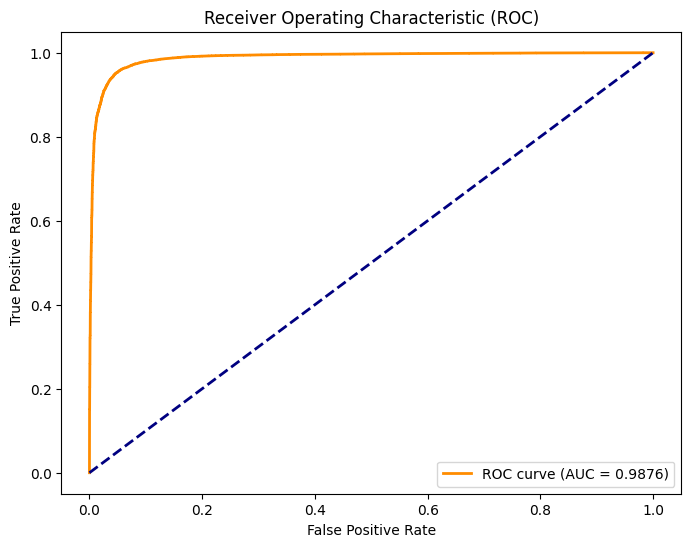

In [82]:
courbe_AUC(cat_boost_best, X_test, y_test)

# grid search

In [64]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna


cat_boost_params = {col : val for col, val in cat_boost_best_params.iloc[0].items()}

In [65]:
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier
import numpy as np
import gc

def objective(trial):
    params = {
        'depth': trial.suggest_categorical('depth', [4, 6, 8]),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [1, 3, 5]),
        'border_count': trial.suggest_categorical('border_count', [32, 64]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.05, 0.1]),
        'iterations': trial.suggest_categorical('iterations', [500, 700]),
        'bagging_temperature': trial.suggest_categorical('bagging_temperature', [0, 1]),
        'random_strength': trial.suggest_categorical('random_strength', [1, 5]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2]),
    }

    model = CatBoostClassifier(
        # task_type="GPU",
        random_state=42,
        verbose=0,
        cat_features=categorical_features,
        **params
    )

    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=3, n_jobs=2)
    gc.collect()
    return np.mean(scores)

study = optuna.create_study(direction='maximize', storage="sqlite:///optuna_grid_search.db", study_name="my_optimization", load_if_exists=True)
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Meilleurs paramètres:", best_params)
print("Meilleur score:", study.best_value)

[I 2025-02-12 09:52:09,690] Using an existing study with name 'my_optimization' instead of creating a new one.
[W 2025-02-12 09:53:04,931] Trial 20 failed with parameters: {'depth': 8, 'l2_leaf_reg': 3, 'border_count': 64, 'learning_rate': 0.1, 'iterations': 700, 'bagging_temperature': 0, 'random_strength': 1, 'scale_pos_weight': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/khadijaabdelmalek/Documents/SIMPLON/BRIEF/Brief_classification/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/s4/wkdjj13x2635cdbxl0dx7yv00000gn/T/ipykernel_46048/1416899276.py", line 27, in objective
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=3, n_jobs=2)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/khadijaabdelmalek/Documents/SIMPLON/BR

KeyboardInterrupt: 

In [ ]:
# Création du modèle final avec les meilleurs paramètres
final_model = CatBoostClassifier(
    random_state=42,
    verbose=100,
    cat_features=categorical_features,
    **best_params
)

# Entraînement du modèle final
final_model.fit(X_train, y_train)

# Utilisation des fonctions d'évaluation
metriques(final_model, X_test, y_test)
courbe_AUC(final_model, X_test, y_test)

# Sauvegarde des meilleurs paramètres
best_params_to_csv(study)